# Population Estimates: Define the income-level strata

In [1]:
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

tqdm.pandas()

In [2]:
# Import functions
%run inference-functions.ipynb import load_data, get_bounds, assign_cbgs, visualize_tile_predvOSM, assign_cbgs_by_coverage
%run ADU_permit_matching-polygon-pipeline.ipynb import load_sources

In [3]:
# Paths
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
SHAPEFILE_FP = '/oak/stanford/groups/deho/building_compliance/shapefiles'
INPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'inputs')
OUTPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'outputs')
PERMIT_INPUT_FP = os.path.join(OAK_FP, 'outputs', 'Permit-Matching', 'inputs')
SJ_RES_PARCELS_FP = os.path.join(PERMIT_INPUT_FP, 'san_jose_parcels_res.geojson')

BUILD_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference-{}', 'inference_building_processed')
OSM_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference-2020', 'osm_building_processed')

# Load data 
cbg_sj_2016 = load_bg_shp(shapefile_fp=SHAPEFILE_FP, oak_fp=OAK_FP, year='2016')

# * Residential parcels
sj_parcels_res = gpd.read_file(SJ_RES_PARCELS_FP)
sj_parcels_res = sj_parcels_res[sj_parcels_res['APN'].notna()]

# * CBG income
cbg_income_2016 = gpd.read_file(os.path.join(INPUT_FP, 'cbg_income_2016'))

## 1. Income-level stratification

Shapefiles include 643 CBGs as of 2016 for San Jose. ACS has non-missing data for 628 CBGs.

Need to define the strata, and which CBGs belong to high/low income regions.

In [4]:
# Filter for SJ CBGs
cbg_income_2016_SJ = cbg_income_2016.loc[cbg_income_2016['GEOID'].isin(cbg_sj_2016['GEOID'].unique())]

In [11]:
# Check missing CBGs and save shapefile of this subset
cbg_income_2016_SJ.info()

cbg_income_2016_SJ.loc[cbg_income_2016_SJ['hh_mdn_'].isna()].to_file(
    os.path.join(OUTPUT_FP, '..', 'misc', 'missing-inc-cbgs'))

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 643 entries, 4 to 1070
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   GEOID     643 non-null    object  
 1   hh_mdn_   628 non-null    float64 
 2   geometry  643 non-null    geometry
dtypes: float64(1), geometry(1), object(1)
memory usage: 20.1+ KB


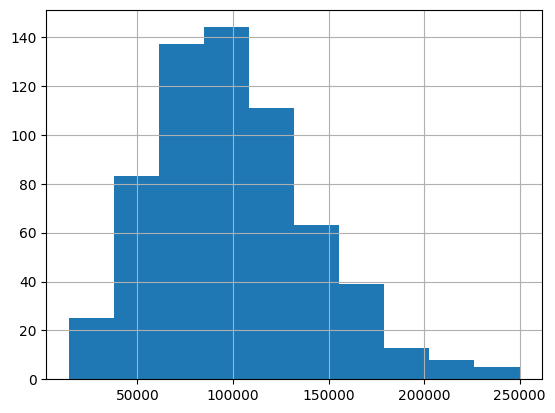

In [12]:
cbg_income_2016_SJ['hh_mdn_'].hist()
plt.show()

In [5]:
# Stratify
N_INCOME_BINS = 50
cbg_income_2016_SJ['strata_income'] = pd.qcut(
    cbg_income_2016_SJ['hh_mdn_'], q=N_INCOME_BINS, 
    labels=['IS_{}'.format(i) for i in range(N_INCOME_BINS)])

In [6]:
# Define high vs. low-income neighborhoods
cbg_income_2016_SJ['neighborhood'] = cbg_income_2016_SJ['strata_income'].apply(
    lambda strata_income: 'low' if int(strata_income.split('_')[1]) < N_INCOME_BINS/2 else 'high'
)

In [9]:
# Convert strata from cateogry to object
cbg_income_2016_SJ['strata_income'] = cbg_income_2016_SJ['strata_income'].astype('object')

In [10]:
# Add strata for the missing CBGs
cbg_income_2016_SJ['strata_income'] = cbg_income_2016_SJ['strata_income'].fillna('IS_MISSING')

In [13]:
cbg_income_2016_SJ.to_file(os.path.join(OUTPUT_FP, 'Strata', 'cbg-income-strata'))

## 2. Assign parcels to CBGs

In [70]:
sj_parcels = sj_parcels_res[['APN', 'geometry']].copy()

In [71]:
# Drop duplicate parcels
sj_parcels.drop_duplicates(subset=['APN'], inplace=True)
print('Number of parcels: {}'.format(len(sj_parcels)))

Number of parcels: 170296


In [72]:
# Assign to CBGs
cbg_income_2016_SJ.reset_index(inplace=True, drop=True)
sj_parcels = sj_parcels.sjoin(cbg_income_2016_SJ[['GEOID', 'geometry']], how='left', predicate='intersects')

sj_parcels['CBG_iou'] = sj_parcels.progress_apply(
    lambda row: 0 if pd.isnull(row['index_right']) else row['geometry'].buffer(0).intersection(
        cbg_income_2016_SJ.iloc[int(row['index_right'])]['geometry'].buffer(0)).area/row['geometry'].buffer(0).area, 
    axis=1)

# Handle multiple matches
sj_parcels.sort_values('CBG_iou', ascending=False, inplace=True)
sj_parcels.drop_duplicates(subset=['APN'], keep='first', inplace=True)

sj_parcels.drop('index_right', axis=1, inplace=True)

print('Number of parcels: {}'.format(len(sj_parcels)))

100%|██████████| 171156/171156 [01:31<00:00, 1880.08it/s]


Number of parcels: 170296


In [73]:
# Save
sj_parcels[['APN', 'GEOID', 'geometry']].to_file(os.path.join(OUTPUT_FP, 'sj-parcels-res-cbgs'))

In [74]:
sj_parcels.head()

,APN,geometry,GEOID,CBG_iou
168334,70616068,"POLYGON ((-121.76364 37.23242, -121.76345 37.2...",060855120352,1.0
127008,74209047,"POLYGON ((-121.80358 37.18987, -121.80359 37.1...",060855119112,1.0
167977,58332069,"POLYGON ((-121.85785 37.21815, -121.85792 37.2...",060855119051,1.0
146573,65432068,"POLYGON ((-121.79014 37.35326, -121.79017 37.3...",060855033122,1.0
121438,49462002,"POLYGON ((-121.81862 37.28808, -121.81862 37.2...",060855032102,1.0


## 3. Compute N_h

Requires the parcel-level confidences. 

In [ ]:
# Parcels
sj_parcels = gpd.read_file(os.path.join(OUTPUT_FP, 'sj-parcels-res-cbgs'))

# Load confidences for each parcel
parcel_confidences = pd.read_csv()

# Save: shp including parcel, GEOID, bin

## 4. Sample parcels